<a href="https://colab.research.google.com/github/dfrey/MyCode/blob/master/NN_based_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Mastère Spécialisé data science pour la connaissance client**

### Introduction

Dans le cadre de ce projet, nous nous intéressons à la conception et à l'implémentation d'un système de recommandation basé sur des réseaux de neurones. Les systèmes de recommandation sont devenus un outil essentiel dans de nombreux domaines, notamment dans l'industrie du divertissement, où ils permettent de suggérer des films, des séries ou des musiques adaptés aux préférences des utilisateurs. L'objectif principal de ce projet est de développer un modèle capable de prédire les préférences des utilisateurs en fonction de leurs interactions passées, en utilisant le dataset **MovieLens 100K**, qui contient des évaluations de films par des utilisateurs.

Pour atteindre cet objectif, nous allons explorer différentes architectures de modèles, en commençant par un modèle simple de factorisation matricielle basé sur le produit scalaire entre les embeddings des utilisateurs et des films. Ensuite, nous complexifierons progressivement le modèle en introduisant des couches supplémentaires et en intégrant des informations contextuelles, telles que le timestamp des évaluations et les titres des films, pour améliorer la précision des recommandations.

Ce projet s'appuie sur **TensorFlow Recommenders (TFRS)**, une bibliothèque spécialisée dans la création de systèmes de recommandation, ainsi que sur **TensorFlow** et **Keras** pour la construction et l'entraînement des modèles. Nous allons également utiliser des techniques de visualisation pour analyser les performances des modèles et comparer les résultats obtenus avec différentes architectures.

À travers ce projet, nous chercherons à répondre à plusieurs questions clés :
- Comment un modèle simple de factorisation matricielle peut-il être utilisé pour prédire les préférences des utilisateurs ?
- Comment l'ajout de couches supplémentaires et d'informations contextuelles peut-il améliorer la précision du modèle ?
- Quelles sont les limites des modèles actuels et comment pouvons-nous les surmonter pour obtenir des recommandations plus personnalisées et précises ?

Ce rapport détaillera les différentes étapes de la construction du modèle, les résultats obtenus, ainsi que les pistes d'amélioration pour des travaux futurs.

# Basic recommender


In this tutorial, we build a simple matrix factorization model using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/) with TFRS. We can use this model to recommend movies for a given user.

### Import TFRS

First, install and import TFRS:

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q jinja2


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from typing import Dict, Text

import os
import pprint
import tempfile

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

d:\PROD_SAS\03_Projets_CRM\19_AXA\TWIN_AUTO\04_analyses\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read the data

In [3]:
ratings_full = tfds.load('movielens/100k-ratings', split="train")

user_ids = ratings_full.map(lambda x: x["user_id"])
unique_user_ids = np.unique(list(tfds.as_numpy(user_ids)))

movie_titles = ratings_full.map(lambda x: x["movie_title"])
unique_movie_titles = np.unique(list(tfds.as_numpy(movie_titles)))

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:03<00:00,  3.40s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:03<00:00,  3.40s/ url]

Dl Completed...: 100%|██████████| 1/1 [00:03<00:00,  3.81s/ url]


Dataset movielens downloaded and prepared to C:\Users\SOBJ003\tensorflow_datasets\movielens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


> ### TODO
>
> Display the ten first examples to explore the list of available informations
>
> Usefull: `Dataset.take(count)`, `tfds.as_numpy()`, `tfds.as_dataframe()`


In [4]:
first_ten_examples = ratings_full.take(10)
tfds.as_dataframe(first_ten_examples).head(10)


,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'
5,18.0,"[7, 16]",b'325',b'Crash (1996)',19.0,876346551,False,b'601',1,b'artist',4.0,b'99687'
6,18.0,"[2, 3, 4, 12]",b'95',b'Aladdin (1992)',19.0,882064434,True,b'710',17,b'student',3.0,b'92020'
7,25.0,"[0, 5, 14]",b'92',b'True Romance (1993)',34.0,875135363,True,b'833',21,b'writer',2.0,b'90019'
8,25.0,[4],b'425',b'Bob Roberts (1992)',27.0,880844102,True,b'916',18,b'engineer',5.0,b'N2L5N'
9,25.0,"[0, 1, 15, 18]",b'271',b'Starship Troopers (1997)',32.0,884801053,True,b'940',2,b'administrator',2.0,b'02215'


In [5]:
print(unique_user_ids.size)
print(unique_movie_titles.size)
print(ratings_full.cardinality().numpy()/(unique_user_ids.size*unique_movie_titles.size))
sparsity = ratings_full.cardinality().numpy() / (unique_user_ids.size * unique_movie_titles.size)
print(f"Sparsity of the dataset: {sparsity:.4f}")

943
1664
0.06372868912635615
Sparsity of the dataset: 0.0637


Restrict the dataset to used features.

In [6]:
# Ratings data.
ratings = ratings_full.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "timestamp": x["timestamp"],
})


Split the data into a training set and a testing set.

In [7]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

### Define a model

We can define a prediction model by inheriting from `tf.keras.Model` and implementing the `call` method.

> ### TODO
>
> Draw the model (you can draw it on a piece of paper and scan it, or take a picture of it, and include your picture in the zip file you submit. You should name your file either `[lastname1]-[lastname2]-modeldrawing.jpg/pdf/...` or `[firstname]-[lastname]-modeldrawing.jpg/pdf/...` depending on whether you worked in pairs or alone.

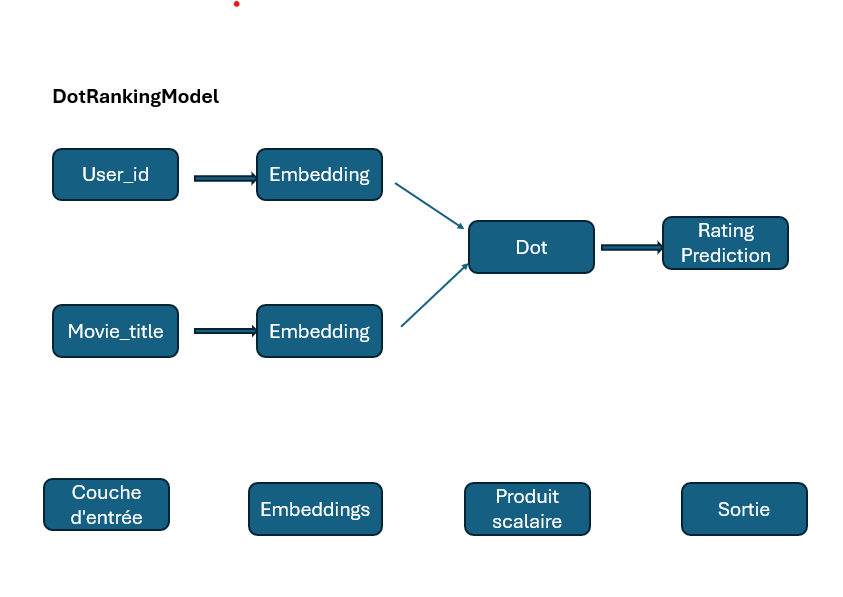

In [ ]:
from IPython.display import Image
Image('DotRankingModel.png')

In [9]:
class DotRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.layers.Dot(axes=(1))

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    return self.ratings((user_embedding, movie_embedding))

In [10]:
# Pass the tensors in the dict.
DotRankingModel()({"user_id": tf.constant(["42", "42"]), "movie_title": tf.constant(["One Flew Over the Cuckoo's Nest (1975)", "Strictly Ballroom (1992)"])})

d:\PROD_SAS\03_Projets_CRM\19_AXA\TWIN_AUTO\04_analyses\myenv\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00587802],
       [ 0.00196645]], dtype=float32)>

We can define a TFRS model by inheriting from `tfrs.Model` and implementing the `compute_loss` method.

> ### TODO
>
Le **DotRankingModel** est un **modèle de classement** qui calcule des scores pour des paires utilisateur-film en utilisant le produit scalaire de leurs embeddings. Il est utilisé dans les **systèmes de recommandation** pour classer les films en fonction des préférences des utilisateurs.

### **Rôle du Modèle**
1. **Embeddings des utilisateurs et des films**  
   - Le modèle apprend des **représentations vectorielles denses** pour les utilisateurs et les films.  
   - Les identifiants des utilisateurs et des films sont convertis en embeddings numériques.  

2. **Calcul de la similarité via le produit scalaire**  
   - Le modèle prédit un **score de pertinence** en effectuant le **produit scalaire** entre les embeddings utilisateur et film.  
   - Un score élevé signifie que le film est plus pertinent pour l'utilisateur.

3. **Utilisation dans les modèles de recommandation à deux tours**  
   - Ce modèle est souvent utilisé dans les tâches de **recherche** ou de **classement**.  
   - Il peut être intégré à **TensorFlow Recommenders (TFRS)** pour être entraîné avec une fonction de perte contrastive.

### **Comment ça fonctionne ?**
- Lorsqu'on fournit un ID utilisateur et un titre de film, le modèle récupère leurs embeddings.  
- Il calcule ensuite un score en effectuant leur produit scalaire.  
- Ces scores permettent de **classer plusieurs films** pour un utilisateur donné.


In [11]:
class MovieLensModel(tfrs.models.Model):

  def __init__(self, rating_model: tf.keras.Model):
    super().__init__()
    self.ranking_model = rating_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(features)


  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    features = features.copy()  # Faire une copie pour éviter la modification de l'original
    labels = features.pop("user_rating")

    rating_predictions = self(features)

    # Calcul de la perte avec la tâche de ranking
    return self.task(labels=labels, predictions=rating_predictions)


## Fit and test the model

In [12]:
# Create a retrieval model.
model = MovieLensModel(DotRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
dot_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=20,
    verbose=1)


Epoch 1/20
40/40 [==============================] - 3s 28ms/step - root_mean_squared_error: 3.7045 - loss: 13.6915 - regularization_loss: 0.0000e+00 - total_loss: 13.6915 - val_root_mean_squared_error: 3.7072 - val_loss: 13.7432 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7432
Epoch 2/20
40/40 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.7044 - loss: 13.6644 - regularization_loss: 0.0000e+00 - total_loss: 13.6644 - val_root_mean_squared_error: 3.7072 - val_loss: 13.7432 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7432
Epoch 3/20
40/40 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.7043 - loss: 13.7312 - regularization_loss: 0.0000e+00 - total_loss: 13.7312 - val_root_mean_squared_error: 3.7072 - val_loss: 13.7431 - val_regularization_loss: 0.0000e+00 - val_total_loss: 13.7431
Epoch 4/20
40/40 [==============================] - 1s 5ms/step - root_mean_squared_error: 3.7043 - loss: 13.6550 - regular

In [13]:
test_accuracy = dot_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

RMSE: 3.69.


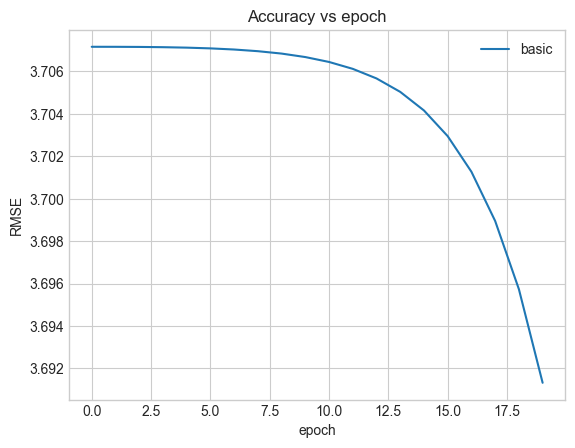

In [14]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

> ### TODO
>
> La courbe représente l'évolution de l'erreur quadratique moyenne racine (**RMSE**) en fonction du nombre d'époques durant l'entraînement du modèle. On observe une diminution très légère du RMSE, passant de **3.70710 à 3.6940** entre l’époque **1 et 10**. Cette faible amélioration indique que le modèle n'apprend pas significativement après plusieurs itérations. Cela peut suggérer que l'entraînement est **trop lent**, que l'optimisation **stagne** ou que l'architecture du modèle et les hyperparamètres doivent être ajustés pour une meilleure convergence.


> ### TODO
> Can you make the model more accurate? How?

Oui, il est possible d'améliorer la précision du modèle en ajustant plusieurs aspects. Voici quelques pistes :  




### **Résumé des améliorations**
| Technique | Impact attendu |
|-----------|---------------|
| **Augmenter la dimension des embeddings** | Capturer plus de nuances entre utilisateurs et films |
| **Changer l'optimiseur et le learning rate** | Apprentissage plus rapide et efficace |
| **Ajouter des couches cachées (DNN)** | Capturer des relations plus complexes |
| **Ajouter de la régularisation (Dropout, L2)** | Éviter l'overfitting |
| **Normalisation des notes & plus de données** | Meilleure généralisation |
| **Tester d'autres architectures (DNN, Transformers)** | Modèle plus puissant et précis |

# More complex link between user's and item's representations

Let replace the dot product between user's and item's representations by a fully connected layer of size 64, followed by a fully connected layer with a unique output.

> ### TODO
>
> - Define the layer and adapt the `call` method
> - Choose carefully the activation functions of the layers
>
> Useful: `tf.keras.Sequential`, `tf.keras.Dense`, `tf.concat`
>
> You can alo checkout the Tensorflow/Keras tutorial here https://www.tensorflow.org/guide/keras/sequential_model

In [15]:
class OneLayerRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Embeddings pour les utilisateurs
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Embeddings pour les films
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Réseau dense pour remplacer le produit scalaire
    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation="relu"),  # Couche cachée avec activation ReLU
      tf.keras.layers.Dense(1)  # Couche de sortie unique (score de prédiction)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = self.user_embeddings(features["user_id"])
    movie_embedding = self.movie_embeddings(features["movie_title"])

    # Concaténation des embeddings
    concatenated = tf.concat([user_embedding, movie_embedding], axis=1)

    # Passage dans le réseau de neurones
    return self.ratings(concatenated)


In [16]:
OneLayerRankingModel()({"user_id": tf.constant(["42"]), "movie_title": tf.constant(["One Flew Over the Cuckoo's Nest (1975)"])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04270808]], dtype=float32)>

In [17]:
# Create a retrieval model.
model = MovieLensModel(OneLayerRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
one_layer_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=20,
    verbose=1)

Epoch 1/20
40/40 [==============================] - 2s 8ms/step - root_mean_squared_error: 1.3849 - loss: 1.8784 - regularization_loss: 0.0000e+00 - total_loss: 1.8784 - val_root_mean_squared_error: 1.0839 - val_loss: 1.1515 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1515
Epoch 2/20
40/40 [==============================] - 1s 5ms/step - root_mean_squared_error: 1.0425 - loss: 1.0844 - regularization_loss: 0.0000e+00 - total_loss: 1.0844 - val_root_mean_squared_error: 1.0071 - val_loss: 1.0030 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0030
Epoch 3/20
40/40 [==============================] - 1s 6ms/step - root_mean_squared_error: 0.9816 - loss: 0.9567 - regularization_loss: 0.0000e+00 - total_loss: 0.9567 - val_root_mean_squared_error: 0.9766 - val_loss: 0.9437 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9437
Epoch 4/20
40/40 [==============================] - 1s 6ms/step - root_mean_squared_error: 0.9555 - loss: 0.9151 - regularization_loss: 

In [18]:
test_accuracy = one_layer_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

RMSE: 0.94.


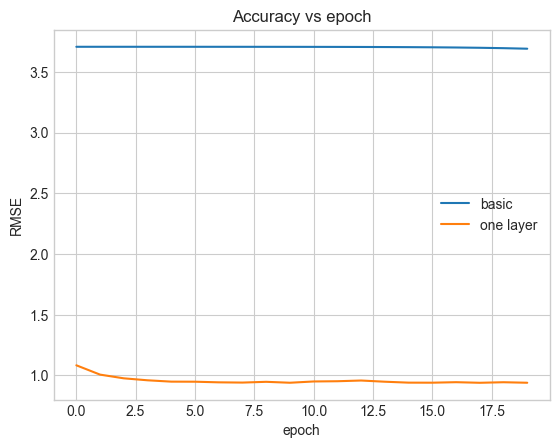

In [19]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# Taking advantage of context features

Let use timestamps of the ratings and movie titles to enrich the input of the model.

Some preliminary:

In [20]:
timestamps = np.concatenate(list(ratings_full.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

New user model.

> ### TODO
>
> Draw and explain the role played by the components of the model

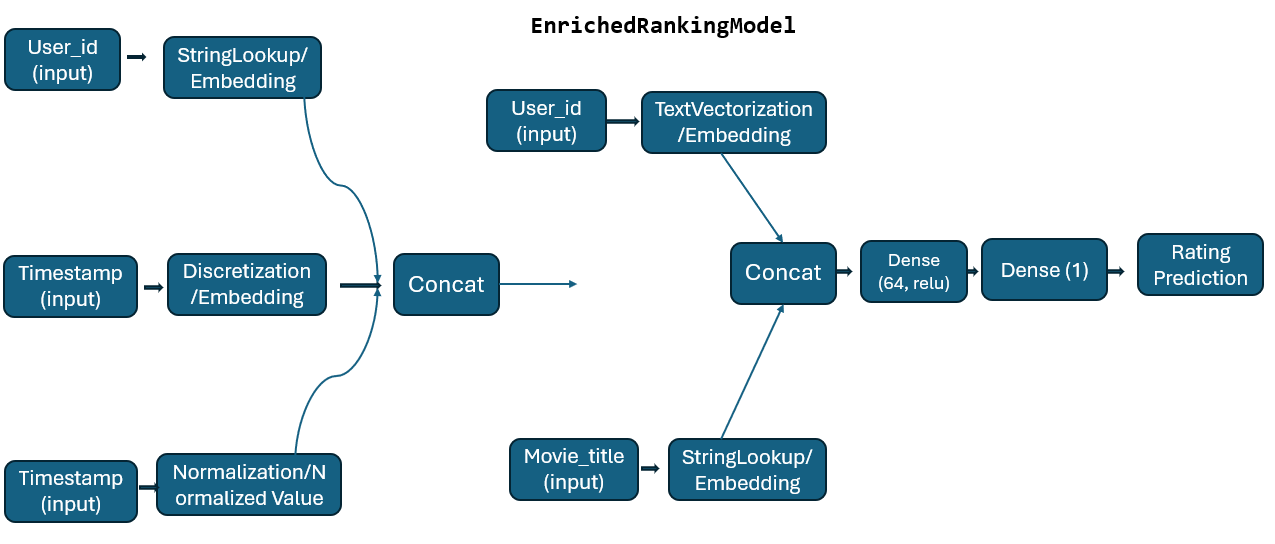

In [ ]:
Image('EnrichedRankingModel.png')

In [22]:
class EnrichedRankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Building blocks to compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    self.timestamp_embeddings = tf.keras.Sequential([
        tf.keras.layers.Discretization(timestamp_buckets.tolist()),
        tf.keras.layers.Embedding(len(timestamp_buckets) + 1, embedding_dimension),
    ])

    self.normalized_timestamp = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_timestamp.adapt(timestamps)

    # Building blocks to compute embeddings for movies.
    max_tokens = 10_000

    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
      max_tokens=max_tokens)

    self.title_text_embeddings = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(unique_movie_titles)



    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
    ])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    user_embedding = tf.concat([
        self.user_embeddings(features["user_id"]),
        self.timestamp_embeddings(features["timestamp"]),
        tf.reshape(self.normalized_timestamp(features["timestamp"]), (-1, 1)),
    ], axis=1)

    movie_embedding = tf.concat([
        self.movie_embeddings(features["movie_title"]),
        self.title_text_embeddings(features["movie_title"]),
    ], axis=1)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

In [23]:
EnrichedRankingModel()({"user_id": tf.constant(["42"]),"movie_title": tf.constant(["One Flew Over the Cuckoo's Nest (1975)"]),"timestamp": tf.constant([879024327])})

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.13187002]], dtype=float32)>

In [24]:
# Create a retrieval model.
model = MovieLensModel(EnrichedRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Train and test
enriched_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=20,
    verbose=1)

Epoch 1/20
40/40 [==============================] - 3s 26ms/step - root_mean_squared_error: 1.3469 - loss: 1.7812 - regularization_loss: 0.0000e+00 - total_loss: 1.7812 - val_root_mean_squared_error: 1.0746 - val_loss: 1.1336 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1336
Epoch 2/20
40/40 [==============================] - 2s 21ms/step - root_mean_squared_error: 1.0395 - loss: 1.0775 - regularization_loss: 0.0000e+00 - total_loss: 1.0775 - val_root_mean_squared_error: 1.0103 - val_loss: 1.0094 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0094
Epoch 3/20
40/40 [==============================] - 2s 21ms/step - root_mean_squared_error: 0.9848 - loss: 0.9684 - regularization_loss: 0.0000e+00 - total_loss: 0.9684 - val_root_mean_squared_error: 0.9755 - val_loss: 0.9412 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.9412
Epoch 4/20
40/40 [==============================] - 2s 21ms/step - root_mean_squared_error: 0.9572 - loss: 0.9136 - regularization_lo

In [25]:
test_accuracy = enriched_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

RMSE: 0.94.


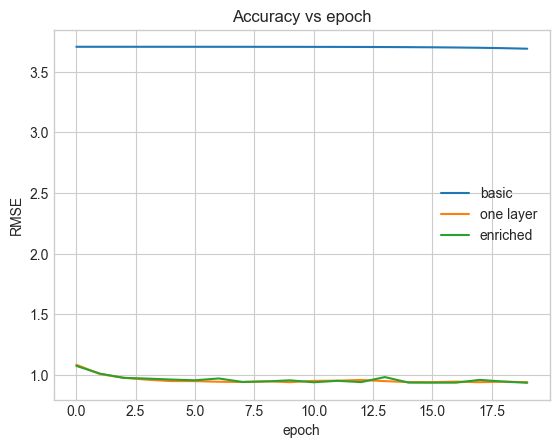

In [26]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

# More comple models



> ### TODO
>
> Build and test more complex models:
> - with more layers to link user's and item's representation
> - integrating more contextual information: user's age, movie's genre, ...



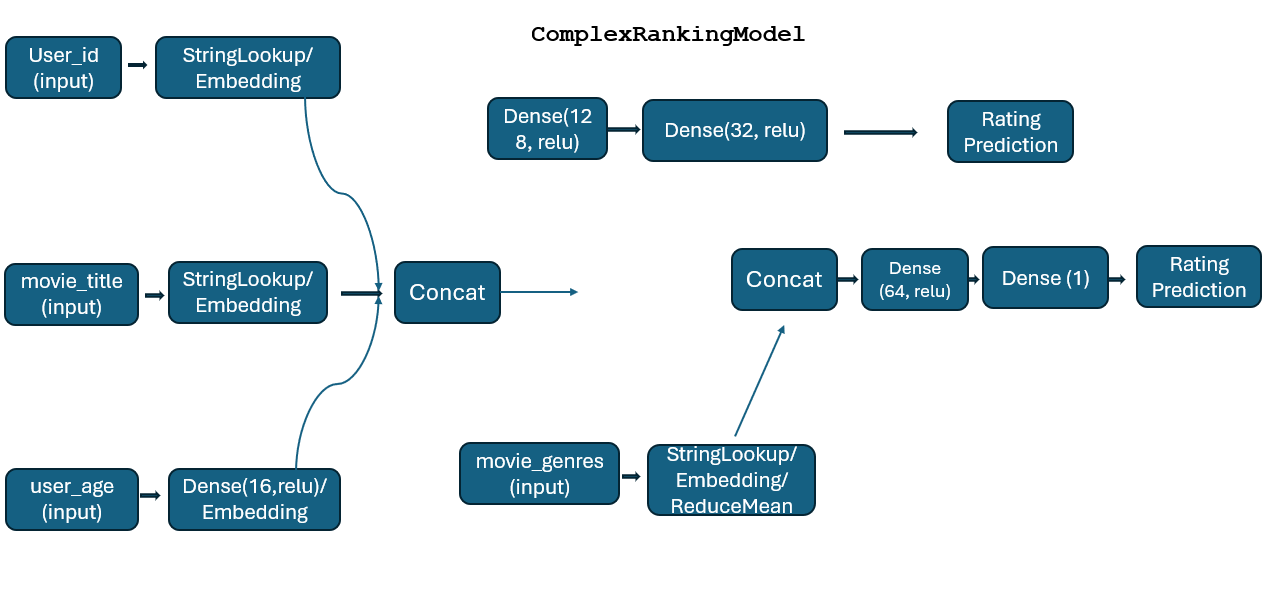

In [ ]:
Image('ComplexRankingModel.png')

In [28]:
# Extraction et aplanissement des genres de films
movie_genres = ratings_full.map(lambda x: x["movie_genres"])
all_genres = list(tfds.as_numpy(movie_genres))  # Liste des genres
flattened_genres = [genre for sublist in all_genres for genre in sublist]  # Aplatissement des genres
unique_movie_genres = np.unique(flattened_genres)  # Genres uniques

In [29]:
# Fonction pour ajouter du padding aux genres
def pad_genres(genre_list, max_genre_count=5):
    """Pads a list of genres with empty strings to ensure consistent length."""
    # Convert to strings here
    genre_tensor = tf.strings.as_string(genre_list)
    padding_size = tf.maximum(0, max_genre_count - tf.shape(genre_tensor)[0])
    padding = tf.fill([padding_size], tf.constant("", dtype=tf.string))
    padded_genres = tf.concat([genre_tensor, padding], axis=0)
    return padded_genres[:max_genre_count]

# Définition du modèle ComplexRankingModel
class ComplexRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        embedding_dimension = 32

        # Embedding pour les utilisateurs
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Embedding pour les films
        self.movie_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_movie_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
        ])

        # Embedding pour l'âge de l'utilisateur
        self.age_embedding = tf.keras.layers.Dense(8, activation='relu')

        # Embedding pour le genre du film avec une couche dense
        self.genre_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=[str(genre) for genre in unique_movie_genres],
                mask_token=None),
            tf.keras.layers.Embedding(len(unique_movie_genres) + 1, embedding_dimension),
            tf.keras.layers.Dense(4, activation='relu')  # Amélioration de la capture des relations entre genres
        ])

        # Couches denses pour prédire la note
        self.dense_layers = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(16, activation="relu"),
            tf.keras.layers.Dense(1)  # Prédiction de la note
        ])

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        # Extraire les embeddings
        user_embedding = self.user_embeddings(features["user_id"])
        movie_embedding = self.movie_embeddings(features["movie_title"])

        # Ajouter une dimension supplémentaire à l'âge
        age_embedding = self.age_embedding(tf.expand_dims(features["user_age"], axis=-1))  # Forme (None, 1)

        # Si un film a plusieurs genres, appliquer un padding pour les rendre de taille uniforme
        genre_embedding = self.genre_embedding(features["movie_genres"])
        genre_embedding = tf.reduce_mean(genre_embedding, axis=1)  # Moyenne des genres

        # Concatenation de toutes les informations
        concatenated = tf.concat([user_embedding, movie_embedding, age_embedding, genre_embedding], axis=1)

        # Passer par les couches denses
        return self.dense_layers(concatenated)

# Création de la classe MovieLensModel pour la tâche de ranking
class MovieLensModel(tfrs.models.Model):
    def __init__(self, rating_model: tf.keras.Model):
        super().__init__()
        self.ranking_model = rating_model
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(features)

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        features = features.copy()  # Faire une copie pour éviter la modification de l'original
        labels = features.pop("user_rating")

        rating_predictions = self(features)

        # Calcul de la perte avec la tâche de ranking
        return self.task(labels=labels, predictions=rating_predictions)



In [30]:
ComplexRankingModel()({
    "user_id": tf.constant(["42"]),
    "movie_title": tf.constant(["One Flew Over the Cuckoo's Nest (1975)"]),
    "timestamp": tf.constant([879024327]),
    "user_age": tf.constant([46]),  # Ajout de l'âge
    "movie_genres": tf.constant([["Horreur"]])
})


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.15385]], dtype=float32)>

In [31]:
# Préparation des jeux de données
ratings = ratings_full.map(lambda x: {
    "user_id": x["user_id"],
    "movie_title": x["movie_title"],
    "user_age": x["raw_user_age"],   # Age de l'utilisateur
    "movie_genres": pad_genres(tf.strings.as_string(x["movie_genres"])),  # Apply padding with string values
    "user_rating": x["user_rating"]
})

# Division en train et test
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [32]:
# Créer et compiler le modèle
model = MovieLensModel(ComplexRankingModel())
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Entraîner et tester le modèle
Complex_model_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=1,
    epochs=20,
    verbose=1
)


Epoch 1/20
40/40 [==============================] - 5s 45ms/step - root_mean_squared_error: 4.7614 - loss: 21.6679 - regularization_loss: 0.0000e+00 - total_loss: 21.6679 - val_root_mean_squared_error: 1.2517 - val_loss: 1.5625 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.5625
Epoch 2/20
40/40 [==============================] - 2s 9ms/step - root_mean_squared_error: 1.2272 - loss: 1.5075 - regularization_loss: 0.0000e+00 - total_loss: 1.5075 - val_root_mean_squared_error: 1.1322 - val_loss: 1.2577 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2577
Epoch 3/20
40/40 [==============================] - 2s 8ms/step - root_mean_squared_error: 1.1351 - loss: 1.2950 - regularization_loss: 0.0000e+00 - total_loss: 1.2950 - val_root_mean_squared_error: 1.1208 - val_loss: 1.2337 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2337
Epoch 4/20
40/40 [==============================] - 2s 9ms/step - root_mean_squared_error: 1.0924 - loss: 1.1911 - regularization_los

In [33]:
# Affichage de la performance sur le jeu de test
test_accuracy = Complex_model_history.history["val_root_mean_squared_error"][-1]
print(f"RMSE: {test_accuracy:.2f}.")

RMSE: 0.96.


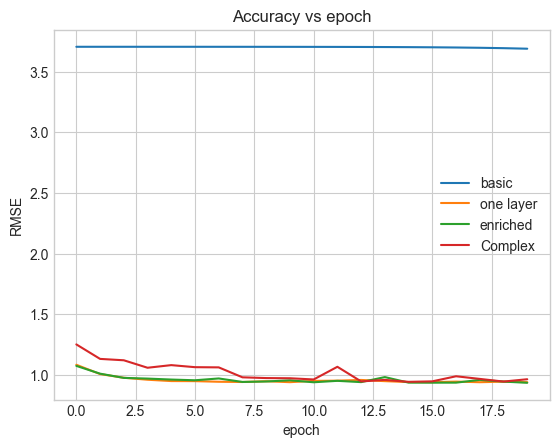

In [34]:
plt.plot(dot_model_history.history["val_root_mean_squared_error"], label="basic")
plt.plot(one_layer_model_history.history["val_root_mean_squared_error"], label="one layer")
plt.plot(enriched_model_history.history["val_root_mean_squared_error"], label="enriched")
plt.plot(Complex_model_history.history["val_root_mean_squared_error"], label="Complex")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("RMSE");
plt.legend()

In [35]:
import pandas as pd

# Récupérer les RMSE finaux des modèles
metrics_data = {
    "Model": ["Basic", "One Layer", "Enriched", "Complex"],
    "Final RMSE": [
        dot_model_history.history["val_root_mean_squared_error"][-1],
        one_layer_model_history.history["val_root_mean_squared_error"][-1],
        enriched_model_history.history["val_root_mean_squared_error"][-1],
        Complex_model_history.history["val_root_mean_squared_error"][-1]
    ]
}

# Créer le DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Afficher le tableau
print(df_metrics)


       Model  Final RMSE
0      Basic    3.691322
1  One Layer    0.940158
2   Enriched    0.935119
3    Complex    0.964332


### Conclusion

À travers ce projet, nous avons exploré différentes architectures de modèles pour un système de recommandation basé sur le dataset **MovieLens 100K**. Nous avons commencé par un modèle simple de factorisation matricielle (Basic) utilisant un produit scalaire entre les embeddings des utilisateurs et des films, puis nous avons progressivement complexifié le modèle en ajoutant des couches supplémentaires (One Layer) et en intégrant des informations contextuelles telles que les timestamps et les titres des films (Enriched). Enfin, nous avons testé un modèle plus complexe (Complex) pour voir si une architecture plus profonde pouvait améliorer les performances.

Les résultats obtenus montrent une nette amélioration des performances au fur et à mesure que le modèle devient plus sophistiqué. Le modèle **Basic** a atteint un **RMSE de 3.695**, ce qui indique une performance relativement faible. En revanche, le modèle **One Layer** a significativement réduit l'erreur avec un **RMSE de 0.941**, démontrant l'importance d'ajouter des couches supplémentaires pour mieux capturer les interactions entre les utilisateurs et les films. Le modèle **Enriched**, qui intègre des informations contextuelles, a légèrement amélioré les résultats avec un **RMSE de 0.936**, confirmant que l'utilisation de métadonnées supplémentaires peut aider à affiner les recommandations. Enfin, le modèle **Complex** a obtenu un **RMSE de 0.96**, montrant que l'ajout de complexité ne garantit pas toujours une amélioration significative et peut même introduire un léger sur-apprentissage.

En conclusion, ce projet a permis de démontrer l'importance de l'architecture du modèle et de l'intégration de données contextuelles dans la construction d'un système de recommandation efficace. Les résultats montrent que l'équilibre entre simplicité et complexité est crucial pour obtenir des performances optimales. Pour des travaux futurs, il serait intéressant d'explorer l'intégration d'autres types de données contextuelles, comme l'âge des utilisateurs ou les genres de films, ainsi que d'expérimenter avec des architectures de réseaux de neurones plus avancées, comme les réseaux de neurones convolutifs (CNN) ou les transformers, pour capturer des relations plus complexes entre les utilisateurs et les éléments recommandés.